In [1]:
import os
from PIL import Image, UnidentifiedImageError
from PIL.TiffTags import TAGS
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import gc
import time

In [2]:
#################################### A MODIFIER SELON SA PROPRE ARBORESCENCE
project_path = 'D:/Projet/mai25_bds_extraction/' 
####################################

raw_data_path = os.path.join(project_path, 'data', 'raw')
processed_data_path = os.path.join(project_path, 'data', 'processed')
rvl_cdip_images_path = os.path.join(raw_data_path, 'RVL-CDIP', 'images')

In [3]:
def get_rvl_cdip_image_files(path):
    tmp_list = []
    for foldername, _, filenames in os.walk(path):
        if filenames:
            filename = filenames[0]
            # we check that the structure is relevant to our expectation with 2 assert
            assert len(filenames) == 1
            if filename.startswith('.'): # avoid to consider files like .DS_Store on mac
                continue
            assert filename.endswith(".tif"), f"{foldername},{filename}"
            tmp_list.append([
                os.path.relpath(foldername, rvl_cdip_images_path),
                filename
            ])
    return pd.DataFrame(tmp_list, columns = ["relative_path", "filename"])


In [4]:
t = time.time()
df = get_rvl_cdip_image_files(rvl_cdip_images_path)
print(f"Duree d'exécution: {time.time() - t:.3f} secondes.")
print(f"({len(df)} images traitées)\n")

df.head()

Duree d'exécution: 103.472 secondes.
(400000 images traitées)



,relative_path,filename
0,imagesa\a\a\a\aaa06d00,50486482-6482.tif
1,imagesa\a\a\a\aaa08d00,2072197187.tif
2,imagesa\a\a\a\aaa09e00,2029372116.tif
3,imagesa\a\a\a\aaa10c00,2085133627a.tif
4,imagesa\a\a\a\aaa11d00,515558347+-8348.tif


## 1. Retrait des marges

In [5]:
def marges(img):
    """
    Détecte les marges haut, bas, gauche, droite d'une image TIFF en mode L.

    Params:
        image_path (str): chemin vers l'image .tiff
    Returns:
        top, bottom, left, right: tailles des marges en pixels
    """
    # 1. récupérer l'image
    img_np = np.array(img)
    height, width = img_np.shape
    
    # Filtre médian pour réduire le bruit ponctuel
    denoised = cv2.medianBlur(img_np, ksize=5)  # ksize impair, typiquement 3 ou 5

    # Floutage gaussien pour lisser avant seuillage
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)

    # Binarisation adaptative sur image débruitée
    binary = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=25,
        C=15
    )
    
    # 4. Projections
    rows_sum = binary.sum(axis=1)
    cols_sum = binary.sum(axis=0)
    # Filtrer les lignes à analyser
    top_bottom_ignore = 30
    side_ignore=50 
    # On enlève les bords parce qu'il peut y avoir des traits noirs dus à un scan de mauvaise qualité
    valid_rows = rows_sum[top_bottom_ignore:height - top_bottom_ignore]
    valid_cols = cols_sum[side_ignore:width - side_ignore]

    if valid_rows.max() == 0 or valid_cols.max() == 0:
        # Aucun texte détecté
        return {'top': 0, 'bottom': height, 'left': 0, 'right': width}

    # Marges haut/bas (avec décalage)
    top = np.argmax(valid_rows > 0) + top_bottom_ignore
    bottom = height - top_bottom_ignore - np.argmax(valid_rows[::-1] > 0)

    # Marges gauche/droite (avec décalage)
    left = np.argmax(valid_cols > 0) + side_ignore
    right = width - side_ignore - np.argmax(valid_cols[::-1] > 0)

    return top, bottom,  left, right

## 2. resize 100 x 100

In [6]:
# en fait, pas besoin d'une fonction vu qu'elle existe déjà x)

## 3. Test sur 1 image

In [7]:
#juste pour la visualisation

def add_black_border(image, border_size=1):
    return cv2.copyMakeBorder(
        image,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # 0 pour noir (mode grayscale)
    )
    

In [8]:
df.head()

,relative_path,filename
0,imagesa\a\a\a\aaa06d00,50486482-6482.tif
1,imagesa\a\a\a\aaa08d00,2072197187.tif
2,imagesa\a\a\a\aaa09e00,2029372116.tif
3,imagesa\a\a\a\aaa10c00,2085133627a.tif
4,imagesa\a\a\a\aaa11d00,515558347+-8348.tif


imagesa\a\a\a\aaa13d00
D:/Projet/mai25_bds_extraction/data_sample\raw\RVL-CDIP\images\imagesa\a\a\a\aaa13d00\514409402_514409407.tif 514409402_514409407.tif


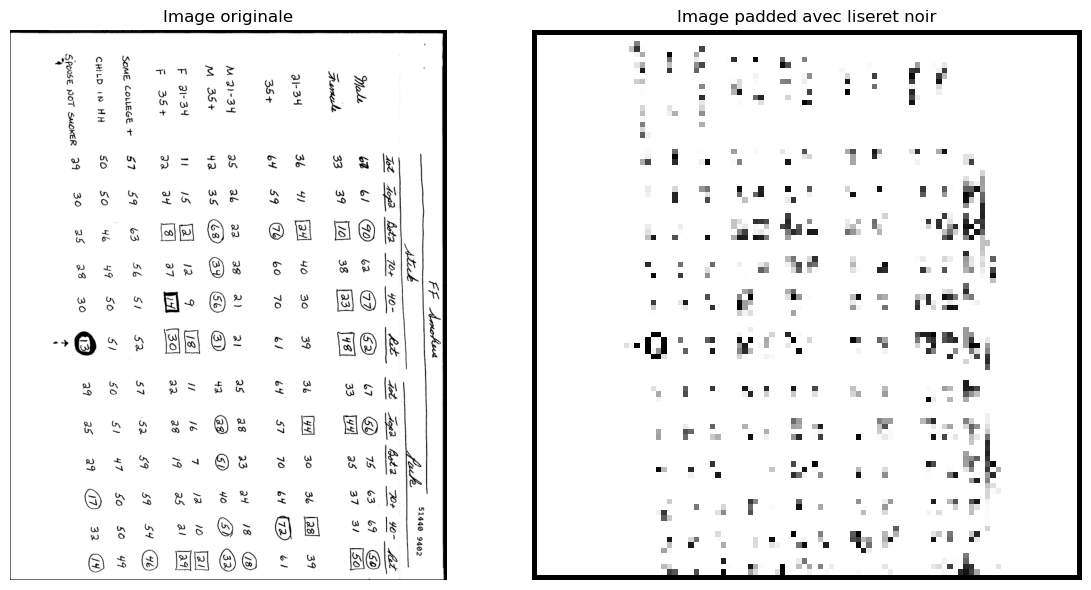

In [16]:
# 1. on récupère l'image
relative_filepath, filename = df.iloc[5, :]
file_path = os.path.join(rvl_cdip_images_path, relative_filepath, filename)
print(relative_filepath)
print(file_path, filename)
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# 2. Détection des marges et recadrage
top, bottom, left, right = marges(img) 
cropped = img[top:bottom, left:right]

# 3. resize
img_resized = cv2.resize(cropped, (100, 100))

# 4 : Redimensionner proportionnellement
h, w = cropped.shape
if h > w:
    new_h = 100
    new_w = int(w * 100 / h)
else:
    new_w = 100
    new_h = int(h * 100 / w)
resized = cv2.resize(cropped, (new_w, new_h))

# 5 Créer un fond blanc 100x100
canvas = np.full((100, 100), 255, dtype=np.uint8)

# 6 : Coller au centre
y_offset = 0  # image collée en haut
x_offset = (100 - new_w) // 2  # centrage horizontal
canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

#on rajoute une forbude pour mieux visualiser les bords
canvas_b = add_black_border(canvas)
img_b = add_black_border(img)

# Affichage
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_b, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Image originale")
axes[0].axis('off')

axes[1].imshow(canvas_b, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Image padded avec liseret noir")
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 4. Application sur l'ensemble des RVL

In [ ]:
def new_image(row):
    input_path = row["input_path"]
    output_dir = row["output_dir"]
    output_path = row["output_path"]

    try:
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return f"Erreur lecture: {input_path}"

        top, bottom, left, right = marges(img)
        cropped = img[top:bottom, left:right]
        img_resized = cv2.resize(cropped, (100, 100))

        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_path, img_resized)

        return None
    except Exception as e:
        return f"Erreur traitement {input_path}: {e}"

In [22]:
def new_image(row):
    input_path = row["input_path"]
    output_dir = row["output_dir"]
    output_path = row["output_path"]

    try:
        img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return f"Erreur lecture: {input_path}"

        # Étape 1 : Rogner
        top, bottom, left, right = marges(img)
        cropped = img[top:bottom, left:right]

        # Étape 2 : Redimensionner proportionnellement
        h, w = cropped.shape
        if h > w:
            new_h = 100
            new_w = int(w * 100 / h)
        else:
            new_w = 100
            new_h = int(h * 100 / w)
        resized = cv2.resize(cropped, (new_w, new_h))

        # Étape 3 : Créer un fond blanc 100x100
        canvas = np.full((100, 100), 255, dtype=np.uint8)

        # Étape 4 : Coller au centre
        y_offset = 0  # image collée en haut
        x_offset = (100 - new_w) // 2  # centrage horizontal
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

        # Sauvegarde
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_path, canvas)

        return None
    except Exception as e:
        return f"Erreur traitement {input_path}: {e}"

def parallelisation(df, n_jobs=5):
    df["input_path"] = rvl_cdip_images_path + os.sep + df["relative_path"] + os.sep + df["filename"]

    df["output_dir"] = df["relative_path"].apply(
        lambda rp: os.path.join(processed_data_path, 'ML_images_100x100', 'RVL-CDIP', 'images', rp))
    df["output_path"] = df.apply(
        lambda row: os.path.join(row["output_dir"], row["filename"]),axis=1)
    data = df.to_dict("records")
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(new_image)(row) for row in data
    )

    erreurs = [r for r in results if r is not None]
    if erreurs:
        print(f"{len(erreurs)} erreurs rencontrées :")
        for e in erreurs[:10]:  # aperçu
            print(e)
    return erreurs

In [23]:
t0 = time.time()
parallelisation(df, n_jobs=5)
print(f"Durée d'exécution: {time.time() - t0:.2f} secondes pour {len(df)} images")

31 erreurs rencontrées :
Erreur traitement D:/Projet/mai25_bds_extraction/data\raw\RVL-CDIP\images\imagesa\a\u\z\auz20a00\60037624.tif: slice indices must be integers or None or have an __index__ method
Erreur traitement D:/Projet/mai25_bds_extraction/data\raw\RVL-CDIP\images\imagesb\b\h\x\bhx70a00\0060150903.tif: slice indices must be integers or None or have an __index__ method
Erreur traitement D:/Projet/mai25_bds_extraction/data\raw\RVL-CDIP\images\imagesb\b\u\z\buz20a00\60037625.tif: slice indices must be integers or None or have an __index__ method
Erreur traitement D:/Projet/mai25_bds_extraction/data\raw\RVL-CDIP\images\imagesd\d\a\x\dax46d00\50639413-9413.tif: OpenCV(4.10.0) C:\b\abs_a3k2mim6t7\croot\opencv-suite_1744821726920\work\modules\imgproc\src\resize.cpp:4155: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'

Erreur traitement D:/Projet/mai25_bds_extraction/data\raw\RVL-CDIP\images\imagesd\d\r\f\drf04e00\2040059568_2040059578.tif: OpenCV(4.10.0) C

## 5. Creation du DataFrame de 10 000 colonnes (1 ligne = 1 image, 1 colonne = 1 pixel)

In [9]:
def images_to_pixel_dataframe(df, include_labels=False, label_column=None):
    records = []
    failed = []
    filenames = []
    file_paths = []

    for _, row in df.iterrows():
        path = row["output_path"]
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                failed.append(path)
                continue
            flat = img.flatten().astype(np.uint8)  # moins de RAM
            if include_labels and label_column in row:
                flat = np.append(flat, row[label_column])
            records.append(flat)
            filenames.append(row["filename"])
            file_paths.append(row["relative_path"])
        except Exception as e:
            failed.append(path)

    n_pixels = 100 * 100
    col_names = [f'p_{i}' for i in range(n_pixels)]
    if include_labels:
        col_names.append(label_column)

    df_pixels = pd.DataFrame(records, columns=col_names)
    df_pixels["filename"] = filenames
    df_pixels["file_path"] = file_paths

    return df_pixels, failed


# ===============================
#  Traitement par batch
# ===============================
def process_in_batches(df, batch_size, processed_data_path, label_column=None):
    output_dir = os.path.join(processed_data_path, "ML_images_100x100")
    os.makedirs(output_dir, exist_ok=True)

    total_batches = len(df) // batch_size + int(len(df) % batch_size != 0)
    all_failed = []

    for i in range(total_batches):
        t0 = time.time()
        df_batch = df.iloc[i * batch_size:(i + 1) * batch_size].copy()
        print(f" Batch {i+1}/{total_batches} - {len(df_batch)} images")

        # Construction des chemins
        df_batch["output_dir"] = df_batch["relative_path"].apply(
            lambda rp: os.path.join(processed_data_path, 'ML_images_100x100', 'RVL-CDIP', 'images', rp)
        )
        df_batch["output_path"] = df_batch.apply(
            lambda row: os.path.join(row["output_dir"], row["filename"]), axis=1
        )

        # Traitement du batch
        df_pixels, failed = images_to_pixel_dataframe(df_batch, include_labels=label_column is not None, label_column=label_column)
        all_failed.extend(failed)

        # Sauvegarde du parquet
        batch_file = os.path.join(output_dir, f"df_pixels_batch_{i:04d}.parquet")
        df_pixels.to_parquet(batch_file)
        print(f" Batch {i+1} terminé en {time.time() - t0:.2f} sec - {len(df_pixels)} images traitées")

        # Nettoyage mémoire
        del df_batch, df_pixels
        gc.collect()

    # Sauvegarde des erreurs
    with open(os.path.join(output_dir, "erreurs_log.txt"), "w") as f:
        for path in all_failed:
            f.write(path + "\n")

    print(f"! Total erreurs: {len(all_failed)}")

# ===============================
#  Concaténation finale
# ===============================
def concat_all_batches(processed_data_path):
    output_dir = os.path.join(processed_data_path, "ML_images_100x100")
    parquet_files = sorted([
        os.path.join(output_dir, f) for f in os.listdir(output_dir)
        if f.startswith("df_pixels_batch_") and f.endswith(".parquet")
    ])

    print(f" Concaténation de {len(parquet_files)} fichiers...")
    df_all = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    df_all.to_parquet(os.path.join(output_dir, "df_pixels.parquet"))
    print(f" Fichier final sauvegardé: df_pixels.parquet ({len(df_all)} images)")

# ===============================
#  Exécution
# ===============================
if __name__ == "__main__":
    # Test sur un petit échantillon (ex: 100 images)
    #df_test = df.sample(n=100, random_state=42).copy()
    #process_in_batches(df_test, batch_size=20, processed_data_path=processed_data_path, label_column=None)
    #concat_all_batches(processed_data_path)
    
    # Suppose que `df` et `processed_data_path` sont déjà définis
    batch_size = 5000  # Ajuste si tu veux moins
    process_in_batches(df, batch_size, processed_data_path, label_column=None)
    concat_all_batches(processed_data_path)

 Batch 1/80 - 5000 images
 Batch 1 terminé en 80.17 sec - 5000 images traitées
 Batch 2/80 - 5000 images
 Batch 2 terminé en 87.46 sec - 5000 images traitées
 Batch 3/80 - 5000 images
 Batch 3 terminé en 73.85 sec - 4999 images traitées
 Batch 4/80 - 5000 images
 Batch 4 terminé en 79.50 sec - 4999 images traitées
 Batch 5/80 - 5000 images
 Batch 5 terminé en 78.16 sec - 5000 images traitées
 Batch 6/80 - 5000 images
 Batch 6 terminé en 76.14 sec - 4999 images traitées
 Batch 7/80 - 5000 images
 Batch 7 terminé en 86.58 sec - 5000 images traitées
 Batch 8/80 - 5000 images
 Batch 8 terminé en 80.81 sec - 5000 images traitées
 Batch 9/80 - 5000 images
 Batch 9 terminé en 80.99 sec - 5000 images traitées
 Batch 10/80 - 5000 images
 Batch 10 terminé en 86.54 sec - 5000 images traitées
 Batch 11/80 - 5000 images
 Batch 11 terminé en 83.39 sec - 5000 images traitées
 Batch 12/80 - 5000 images
 Batch 12 terminé en 77.06 sec - 5000 images traitées
 Batch 13/80 - 5000 images
 Batch 13 terminé e

In [10]:
df_test = pd.read_parquet(os.path.join(processed_data_path, "ML_images_100x100", "df_pixels.parquet"))
df_test

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_9992,p_9993,p_9994,p_9995,p_9996,p_9997,p_9998,p_9999,filename,file_path
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,50486482-6482.tif,imagesa\a\a\a\aaa06d00
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2072197187.tif,imagesa\a\a\a\aaa08d00
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2029372116.tif,imagesa\a\a\a\aaa09e00
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2085133627a.tif,imagesa\a\a\a\aaa10c00
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,515558347+-8348.tif,imagesa\a\a\a\aaa11d00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399982,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2064857737.tif,imagesz\z\z\z\zzz77d00
399983,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2057775423.tif,imagesz\z\z\z\zzz83c00
399984,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2073684077.tif,imagesz\z\z\z\zzz85c00
399985,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,2070718633.tif,imagesz\z\z\z\zzz86c00


In [9]:
def images_to_pixel_dataframe(df, include_labels=False, label_column=None):
    records = []
    failed = []
    filenames = []
    file_paths = []

    for _, row in df.iterrows():
        path = row["output_path"]
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                failed.append(path)
                continue
            flat = img.flatten()
            if include_labels and label_column in row:
                flat = np.append(flat, row[label_column])
            records.append(flat)
            filenames.append(row["filename"])
            file_paths.append(row["relative_path"])
        except Exception as e:
            print(f"Erreur avec {path}: {e}")
            failed.append(path)

    n_pixels = 100 * 100
    col_names = [f'p_{i}' for i in range(n_pixels)]
    if include_labels:
        col_names.append(label_column)

    df_pixels = pd.DataFrame(records, columns=col_names)
    df_pixels["filename"] = filenames
    df_pixels["file_path"] = file_paths

    return df_pixels, failed

In [ ]:
# Sélection de 100 lignes aléatoires
#df_sample = df.sample(n=1000, random_state=42)  # random_state pour reproductibilité

t0 = time.time()
# Création du DataFrame des pixels
df["output_dir"] = df["relative_path"].apply(
        lambda rp: os.path.join(processed_data_path, 'ML_images_100x100', 'RVL-CDIP', 'images', rp))
df["output_path"] = df.apply(
        lambda row: os.path.join(row["output_dir"], row["filename"]),axis=1)
df_pixels, erreurs = images_to_pixel_dataframe(df)
df_pixels.to_parquet(os.path.join(processed_data_path,"ML_images_100x100", "df_pixels.parquet"))
print(f"Durée d'exécution: {time.time() - t0:.2f} secondes pour {len(df)} images")

In [58]:
# 1. Sélectionner les colonnes de pixels
pixel_cols = [col for col in df_pixels.columns if col.startswith("p_")]

# 2. Prendre les 5 premières images
subset = df_pixels.loc[:4, pixel_cols]  # lignes 0 à 4

# 3. Garder les colonnes où au moins un pixel ≠ 255
useful_cols = subset.loc[:, subset.nunique() > 1].columns
selected_cols = useful_cols[:10]
cols_to_display = list(selected_cols) + ['filename', 'file_path']

In [60]:
df_pixels.loc[:4, cols_to_display]

,p_13,p_14,p_16,p_21,p_22,p_25,p_27,p_35,p_36,p_40,filename,file_path
0,255,255,86,251,255,255,255,255,255,255,518213443+-3446.tif,D:/Projet/mai25_bds_extraction/data\raw\RVL-CD...
1,255,255,255,255,255,255,255,255,255,255,2076791044.tif,D:/Projet/mai25_bds_extraction/data\raw\RVL-CD...
2,255,255,255,242,234,254,219,255,252,255,502594696.tif,D:/Projet/mai25_bds_extraction/data\raw\RVL-CD...
3,255,255,255,255,255,255,255,255,255,255,50580367-0368.tif,D:/Projet/mai25_bds_extraction/data\raw\RVL-CD...
4,229,199,255,255,255,255,255,221,254,185,2057434474.tif,D:/Projet/mai25_bds_extraction/data\raw\RVL-CD...
